In [1]:
import numpy as np
import pandas as pd
import warnings
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)

In [2]:
import pandas as pd
suzuki=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_from_pistachio.csv')

In [3]:
suzuki.head(2)

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Unnamed: 0,0,1,2,3,4,is_base_template
0,1474,[CH3:1][c:2]1[cH:3][cH:4][c:5]([n:6]1-[c:7]1[c...,US20010007873A1_0204,"EXAMPLE 15, Step D",3.1.5,Bromo Suzuki-type coupling,True
1,1485,[CH3:1][c:2]1[cH:3][cH:4][c:5]([n:6]1-[c:7]1[c...,US20010007873A1_0242,"EXAMPLE 20, Step F",3.1.5,Bromo Suzuki-type coupling,True


In [4]:
#data_test=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/data_with_ASKCOS_score.csv')
data_test=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_with_label_180_with_sim.csv')

In [5]:
#from similarity_v1 import get_rxn_maccs, cal_rxn_dice_similarity, get_max_similarity
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)

def get_rxnfp(rxn):
    model, tokenizer = get_default_model_and_tokenizer()
    rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)
    fp = rxnfp_generator.convert(rxn)
    return fp

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#from scipy import spatial
def get_similarity(va,vb):
    # sim0=1 - spatial.distance.cosine(va[0],vb[0])
    # sim1=1 - spatial.distance.cosine(va[1],vb[1])
    # sim2=1 - spatial.distance.cosine(va[2],vb[2])
    va=np.array(va).reshape(-1)
    vb=np.array(vb).reshape(-1)
    # sim0=va[0].dot(vb[0]) / (np.linalg.norm(va[0]) * np.linalg.norm(vb[0]))
    # sim1=va[2].dot(vb[1]) / (np.linalg.norm(va[1]) * np.linalg.norm(vb[1]))
    # sim2=va[2].dot(vb[2]) / (np.linalg.norm(va[2]) * np.linalg.norm(vb[2]))
    # sim=(sim0+sim1+sim2)/3
    sim=va.dot(vb) / (np.linalg.norm(va) * np.linalg.norm(vb))
    return sim 
  
def get_max_similarity(emb,emb_list):
    sim_list=[]
    for j in emb_list:
        sim=get_similarity(emb,j)
        #if sim!=1:
        sim_list.append(sim)
    max_sim=max(sim_list)
    return max_sim
    

In [7]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
suzuki['rxnfp']=suzuki['0'].progress_apply(lambda x: get_rxnfp(x))

In [17]:
data_test['rxnfp']=data_test['rxn_smiles_x'].progress_apply(lambda x: get_rxnfp(x))

100%|██████████| 180/180 [00:07<00:00, 24.98it/s]


In [18]:
emb_list=suzuki['rxnfp'].tolist()

In [19]:
data_test['max_rxnfp_sim']=data_test['rxnfp'].progress_apply(lambda x: get_max_similarity(x,emb_list))

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [04:03<00:00,  1.35s/it]


In [20]:
data_test['max_rxnfp_sim'].describe()

count    180.000000
mean       0.914320
std        0.077247
min        0.720621
25%        0.911899
50%        0.939055
75%        0.973991
max        0.986263
Name: max_rxnfp_sim, dtype: float64

In [21]:
data_test.head()

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Unnamed: 0.1,Unnamed: 0,index,rxn_smiles_x,maccs,max_maccs_sim,label_x,rxn_smiles_y,ecfp,max_ecfp_sim,...,sim_range,label_x1,spilt_rxn,phbr_embedding,phB_embedding,product_embedding,total_embedding,max_sim,rxnfp,max_rxnfp_sim
0,0,90004,19432,OCc1c(Cl)ccnc1SCI.OPCCc1cccc(B(O)O)c1>>OCc1c(-...,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.741772,N,NaN,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.560707,...,0.90-0.95,N,"('OCc1c(Cl)ccnc1SCI', 'OPCCc1cccc(B(O)O)c1', '...",[-1.03580427e+00 -5.06800234e-01 4.99885619e-...,[-9.18839812e-01 -4.97756481e-01 2.20456213e-...,[-1.41091955e+00 -3.65005583e-01 2.71567732e-...,"[array([-1.03580427e+00, -5.06800234e-01, 4.9...",0.940257,"[0.37682923674583435, 1.7164520025253296, 0.63...",0.916603
1,1,90030,18760,CSc1cc(Cl)ccn1.OPCCc1cccc(B(O)O)c1>>CSc1cc(-c2...,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.728289,N,NaN,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.558877,...,0.90-0.95,N,"('CSc1cc(Cl)ccn1', 'OPCCc1cccc(B(O)O)c1', 'CSc...",[-1.19833159e+00 -6.61193430e-01 4.97321486e-...,[-9.18839812e-01 -4.97756481e-01 2.20456213e-...,[-1.47810376e+00 -4.08370018e-01 1.85908452e-...,"[array([-1.19833159e+00, -6.61193430e-01, 4.9...",0.950632,"[0.4058639407157898, 1.826808214187622, 0.4755...",0.923658
2,2,90035,67367,Sc1cc(I)cc(CCl)n1.OB(O)c1cccc(CCP)c1>>PCCc1ccc...,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.724359,N,NaN,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.492982,...,0.90-0.95,N,"('Sc1cc(I)cc(CCl)n1', 'OB(O)c1cccc(CCP)c1', 'P...",[-1.17158675e+00 -3.27279091e-01 3.93064380e-...,[-0.939946 -0.39246538 0.3202891 0.262908...,[-1.36638355e+00 -1.67332903e-01 1.09455019e-...,"[array([-1.17158675e+00, -3.27279091e-01, 3.9...",0.934497,"[0.7474513649940491, 2.600860357284546, 0.9876...",0.900337
3,3,90033,10696,OCSc1cnc(F)cn1.OPCCc1cccc(B(O)O)c1>>OCSc1cnc(-...,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.726351,N,NaN,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.537712,...,0.75-0.80,N,"('OCSc1cnc(F)cn1', 'OPCCc1cccc(B(O)O)c1', 'OCS...",[-9.86927807e-01 -7.36398876e-01 3.82744670e-...,[-9.18839812e-01 -4.97756481e-01 2.20456213e-...,[-1.30678010e+00 -3.27114135e-01 2.90261000e-...,"[array([-9.86927807e-01, -7.36398876e-01, 3.8...",0.942368,"[-1.22475004196167, 2.123462438583374, -0.2548...",0.784117
4,4,89951,31752,CCc1ncccc1F.OPCCc1cccc(B(O)O)c1>>CCc1ncccc1-c1...,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.749346,N,NaN,[<rdkit.DataStructs.cDataStructs.ExplicitBitVe...,0.528947,...,0.70-0.75,N,"('CCc1ncccc1F', 'OPCCc1cccc(B(O)O)c1', 'CCc1nc...",[-1.8276998 -0.7583008 0.40806213 -0.240363...,[-9.18839812e-01 -4.97756481e-01 2.20456213e-...,[-1.77191758e+00 -4.78436679e-01 2.71993965e-...,"[array([-1.8276998 , -0.7583008 , 0.40806213,...",0.945646,"[-0.999699056148529, 1.8597333431243896, -0.09...",0.735933


<Figure size 800x600 with 0 Axes>

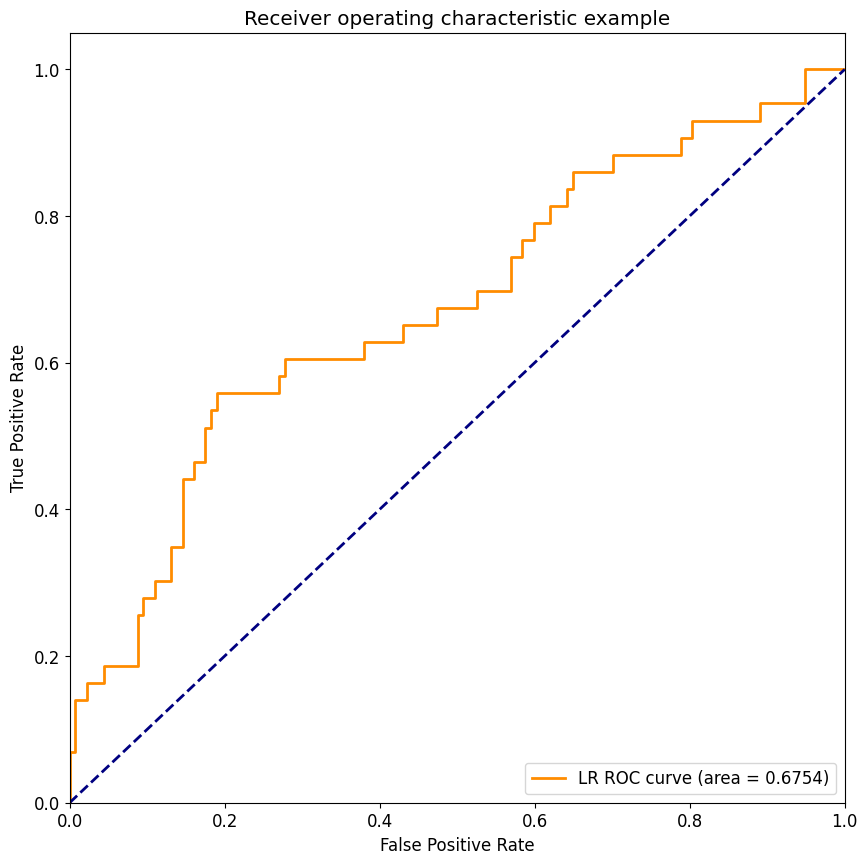

In [ ]:
import matplotlib.pyplot as plt
data_test['label_x1'] = data_test['label_x'].replace('S', 'Y')
label_dict = {'N': 0, 'Y': 1}
y_true = data_test['label_x1'].map(label_dict).values
y_scores = data_test['max_rxnfp_sim'].values
from sklearn import metrics
fpr,tpr,thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
roc_auc = metrics.auc(fpr,tpr)  # 计算auc的值

# 绘制roc曲线
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',lw=lw,label='LR ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##### correlation analysis


/tmp/ipykernel_288115/3965147528.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_test.groupby(['sim_range', 'label_x1']).size().unstack()


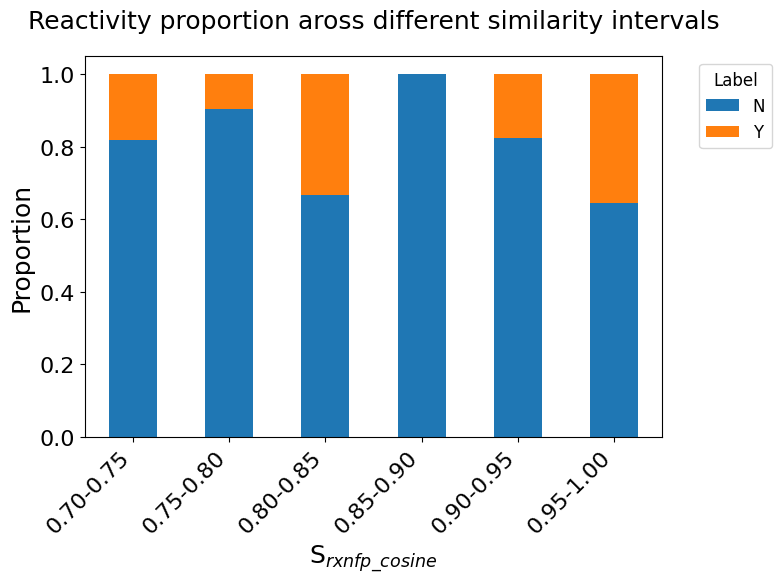

In [ ]:
import matplotlib.pyplot as plt
bins = [0.70, 0.75, 0.80, 0.85,0.90,0.95,1.00]
labels = ['0.70-0.75', '0.75-0.80','0.80-0.85', '0.85-0.90','0.90-0.95','0.95-1.00']
data_test['sim_range'] = pd.cut(data_test['max_rxnfp_sim'], bins=bins, labels=labels)
grouped = data_test.groupby(['sim_range', 'label_x1']).size().unstack()

total = grouped.sum(axis=1)
proportions = grouped.apply(lambda x: x / total)

# 设置图表大小和字体大小
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 12

# 绘制堆叠条形图
ax = proportions.plot(kind='bar', stacked=True)

# 设置标题、标签和图例
ax.set_title('Reactivity proportion aross different similarity intervals',fontsize=18,pad=20)
ax.set_xlabel('S$_{rxnfp\_cosine}$',fontsize=18)
ax.set_ylabel('Proportion',fontsize=18)
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=16)

# 调整布局
plt.tight_layout()

# 显示图表
#plt.show()
plt.savefig('Figure 5c(YN).png',dpi=600)

In [30]:
from scipy.stats import spearmanr

# 计算相似度与反应活性之间的斯皮尔曼相关系数
corr, p_value = spearmanr(data_test['max_rxnfp_sim'], data_test['label_x1'], nan_policy='omit')

# 打印相关系数和p值
# print('Spearman correlation coefficient: {:.3f}'.format(corr))
# print('p-value: {:.3f}'.format(p_value))
print('Spearman correlation coefficient: ',corr)
print('p-value:',p_value)


Spearman correlation coefficient:  0.2591437802279584
p-value: 0.00044347978564011583


In [ ]:
#data_test.to_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_with_label_180_with_sim.csv',index=False)

In [31]:
#data_generate=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/generate_model/new_rxn_df_subset.csv')
data_generate=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/generate_model/new_rxn_df.csv')

In [32]:
data_generate['rxnfp']=data_generate['rxn_smiles'].progress_apply(lambda x: get_rxnfp(x))

100%|██████████| 90048/90048 [1:03:18<00:00, 23.70it/s]


In [40]:
data_generate['max_rxnfp_sim']=data_generate['rxnfp'].progress_apply(lambda x: get_max_similarity(x,emb_list))

100%|██████████| 90048/90048 [33:52:56<00:00,  1.35s/it]   


In [41]:
data_generate['max_rxnfp_sim'].describe()

count    90048.000000
mean         0.901602
std          0.090588
min          0.588658
25%          0.797572
50%          0.941384
75%          0.974519
max          0.989533
Name: max_rxnfp_sim, dtype: float64

In [42]:
data_generate.to_pickle('new_generated_suzuki_with_rxnfp_sim_true_structure.pkl')

In [ ]:

data_generate=pd.read_pickle(('new_generated_suzuki_with_rxnfp_sim_true_structure.pkl'))

In [43]:
data_generate.head(1)

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Unnamed: 0,rxn_smiles,rxnfp,max_rxnfp_sim
0,0,Brc1ccccc1.OB(O)c1ccccc1>>c1ccc(-c2ccccc2)cc1,"[-0.8974076509475708, 3.1396889686584473, 0.20...",0.981296


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Histogram of generated reactions similarity')

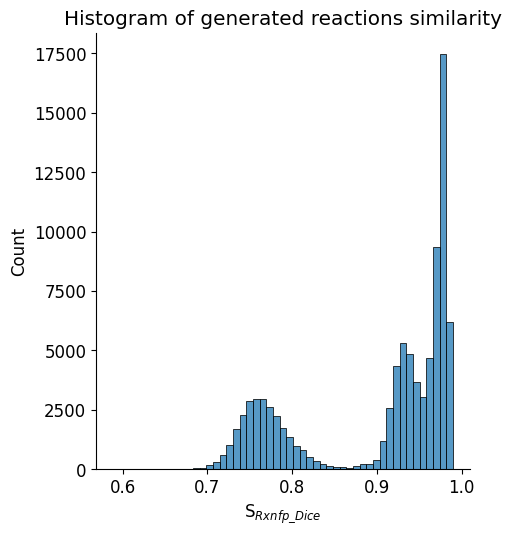

In [45]:
sns.displot(data=data_generate['max_rxnfp_sim'].to_numpy())
# plt.legend()
plt.xlabel('S$_{Rxnfp\_Dice}$')
plt.title('Histogram of generated reactions similarity')

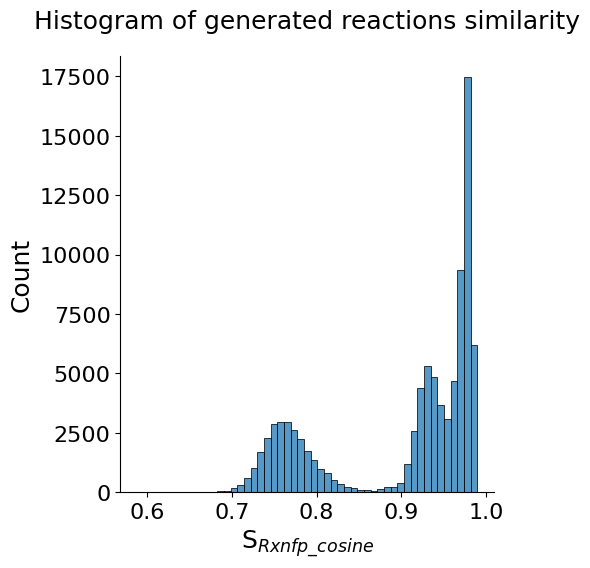

In [50]:
sns.displot(data=data_generate['max_rxnfp_sim'].to_numpy())
plt.xlabel('S$_{Rxnfp\_cosine}$',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Histogram of generated reactions similarity',fontsize=18,pad=20)
plt.savefig('Figure 4d(Rxnfp).jpg',dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'pdf of generated reactions similarity')

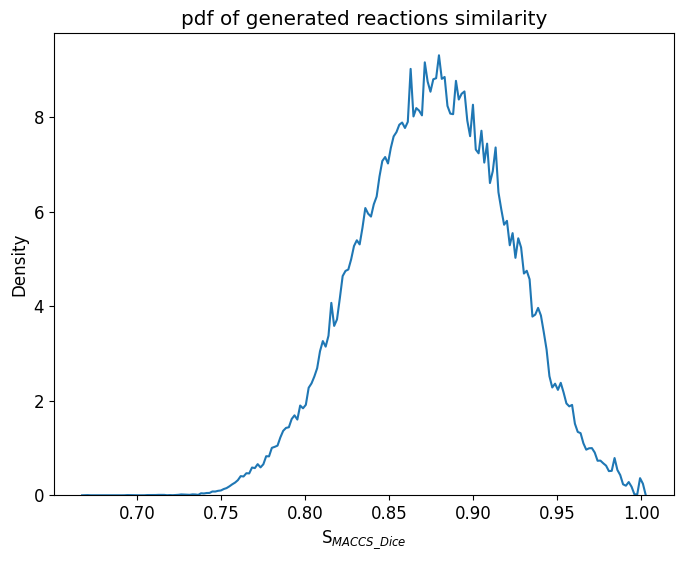

In [ ]:
sns.kdeplot(data=data_generate['max_maccs_sim'].to_numpy(), bw_adjust=.2)
plt.xlabel('S$_{Rxnfp\_Dice}$')
plt.title('pdf of generated reactions similarity')